- *Note:* **This project was taken from a Kaggle Repository '[Fraud Detection Modeling Guidebook: A to Z](https://www.kaggle.com/code/hobeomlee/fraud-detection-modeling-guidebook-a-to-z/notebook)' by *@hobeomlee*. It was used by me, for training and exploration purposes and may use/add different tools or ways to approach.**

- **It helped me understanding the proper steps to follow while doing a project in (specially) Data Science and how to search evidences to get better insights from the available data and also. Beyond that, it shows a good way to organize and document our leads.**

In [ ]:
# IMPORTS

# NULL VALUES
import missingno as msno

# VISUALIZATION
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

# ENCODING
from sklearn.preprocessing import LabelEncoder

# OUTLIERS
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
import lightgbm as lgb

# OVERSAMPLING
from imblearn.over_sampling import SMOTE

# CROSSVALIDATION
from sklearn.feature_selection import RFECV, VarianceThreshold
from sklearn.model_selection import StratifiedKFold

# ML PREPARATION
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report

# ML ALGORITHMS
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier, HistGradientBoostingClassifier
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.gaussian_process import GaussianProcessClassifier

import optuna


# ML - FEATURE IMPORTANCE
from sklearn.inspection import permutation_importance

# DATA
import numpy as np
import pandas as pd
pd.options.display.max_columns = None

# 📊 01. Descriptive Analysis 📊

In [2]:
data_path = 'data/fraud_oracle.csv'
raw_data = pd.read_csv(data_path)
raw_data.shape

(15420, 33)

#### 1) Definition of Features
- **Month**                : Month of accident                               
- **WeekOfMonth**          : Week of accident                                
- **DayOfWeek**            : Day of accident                                 
- **Make**                 : Manufacture company of car (19 companies)       
- **AccidentArea**         : Area where accident took place (Rural or Urban) 
- **DayOfWeekClaimed**     : Day of filing Insurance claim                   
- **MonthClaimed**         : Month of filing Insurance claim                 
- **WeekOfMonthClaimed**   : Week of filing Insurance claim                  
- **Sex**                  : Gender of Insurance claimant (Male or Female)   
- **MaritalStatus**        : Single, married, widow and divorced             
- **Age**                  : Age of Insurance policy holder                  
- **Fault**                : Policy holder or third party                    
- **PolicyType**           : Type of policies issued (1-9)                   
- **VehicleCategory**      : Sedan, sport or utility                         
- **VehiclePrice**         : Price of vehicle (6 categories)                 
- **FraudFound_P**         : Binary Class (Yes or No)                        
- **PolicyNumber**         : Policy number issued to customer
- **RepNumber**            : ID of the person who handle the claim (16 categories)            
- **Deductible**           : Amount to be deducted before claim disbursement                  
- **DriverRating**         : Experience of the driver (4 categories)                          
- **Days_Policy_Accident** : Days left in policy since accident                               
- **Days_Policy_Claim**    : Days left in policy since filing of a claim                      
- **PastNumberOfClaims**   : Past number of claims filed by customer                          
- **AgeOfVehicle**         : Age of the vehicle (8 categories)                                
- **AgeOfPolicyHolder**    : Policy holder’s age (9 categories)                               
- **PoliceReportFiled**    : Police report filed after accident (Yes or No)                   
- **WitnessPresent**       : Witness present during accident (Yes or No)                      
- **AgentType**            : Type of insurance agent (Internal or External)                   
- **NumberOfSuppliments**  : Number of supplements                                            
- **AddressChange_Claim**  : Number of times change of address requested by insurance claimant
- **NumberOfCars**         : Number of cars owned by the claimant                             
- **Year**                 : Year – 1994, 1995 and 1996                                       
- **BasePolicy**           : Base policy of the insurance (3 categories)                      

In [3]:
raw_data.head()

,Month,WeekOfMonth,DayOfWeek,Make,AccidentArea,DayOfWeekClaimed,MonthClaimed,WeekOfMonthClaimed,Sex,MaritalStatus,Age,Fault,PolicyType,VehicleCategory,VehiclePrice,FraudFound_P,PolicyNumber,RepNumber,Deductible,DriverRating,Days_Policy_Accident,Days_Policy_Claim,PastNumberOfClaims,AgeOfVehicle,AgeOfPolicyHolder,PoliceReportFiled,WitnessPresent,AgentType,NumberOfSuppliments,AddressChange_Claim,NumberOfCars,Year,BasePolicy
0,Dec,5,Wednesday,Honda,Urban,Tuesday,Jan,1,Female,Single,21,Policy Holder,Sport - Liability,Sport,more than 69000,0,1,12,300,1,more than 30,more than 30,none,3 years,26 to 30,No,No,External,none,1 year,3 to 4,1994,Liability
1,Jan,3,Wednesday,Honda,Urban,Monday,Jan,4,Male,Single,34,Policy Holder,Sport - Collision,Sport,more than 69000,0,2,15,400,4,more than 30,more than 30,none,6 years,31 to 35,Yes,No,External,none,no change,1 vehicle,1994,Collision
2,Oct,5,Friday,Honda,Urban,Thursday,Nov,2,Male,Married,47,Policy Holder,Sport - Collision,Sport,more than 69000,0,3,7,400,3,more than 30,more than 30,1,7 years,41 to 50,No,No,External,none,no change,1 vehicle,1994,Collision
3,Jun,2,Saturday,Toyota,Rural,Friday,Jul,1,Male,Married,65,Third Party,Sedan - Liability,Sport,20000 to 29000,0,4,4,400,2,more than 30,more than 30,1,more than 7,51 to 65,Yes,No,External,more than 5,no change,1 vehicle,1994,Liability
4,Jan,5,Monday,Honda,Urban,Tuesday,Feb,2,Female,Single,27,Third Party,Sport - Collision,Sport,more than 69000,0,5,3,400,1,more than 30,more than 30,none,5 years,31 to 35,No,No,External,none,no change,1 vehicle,1994,Collision


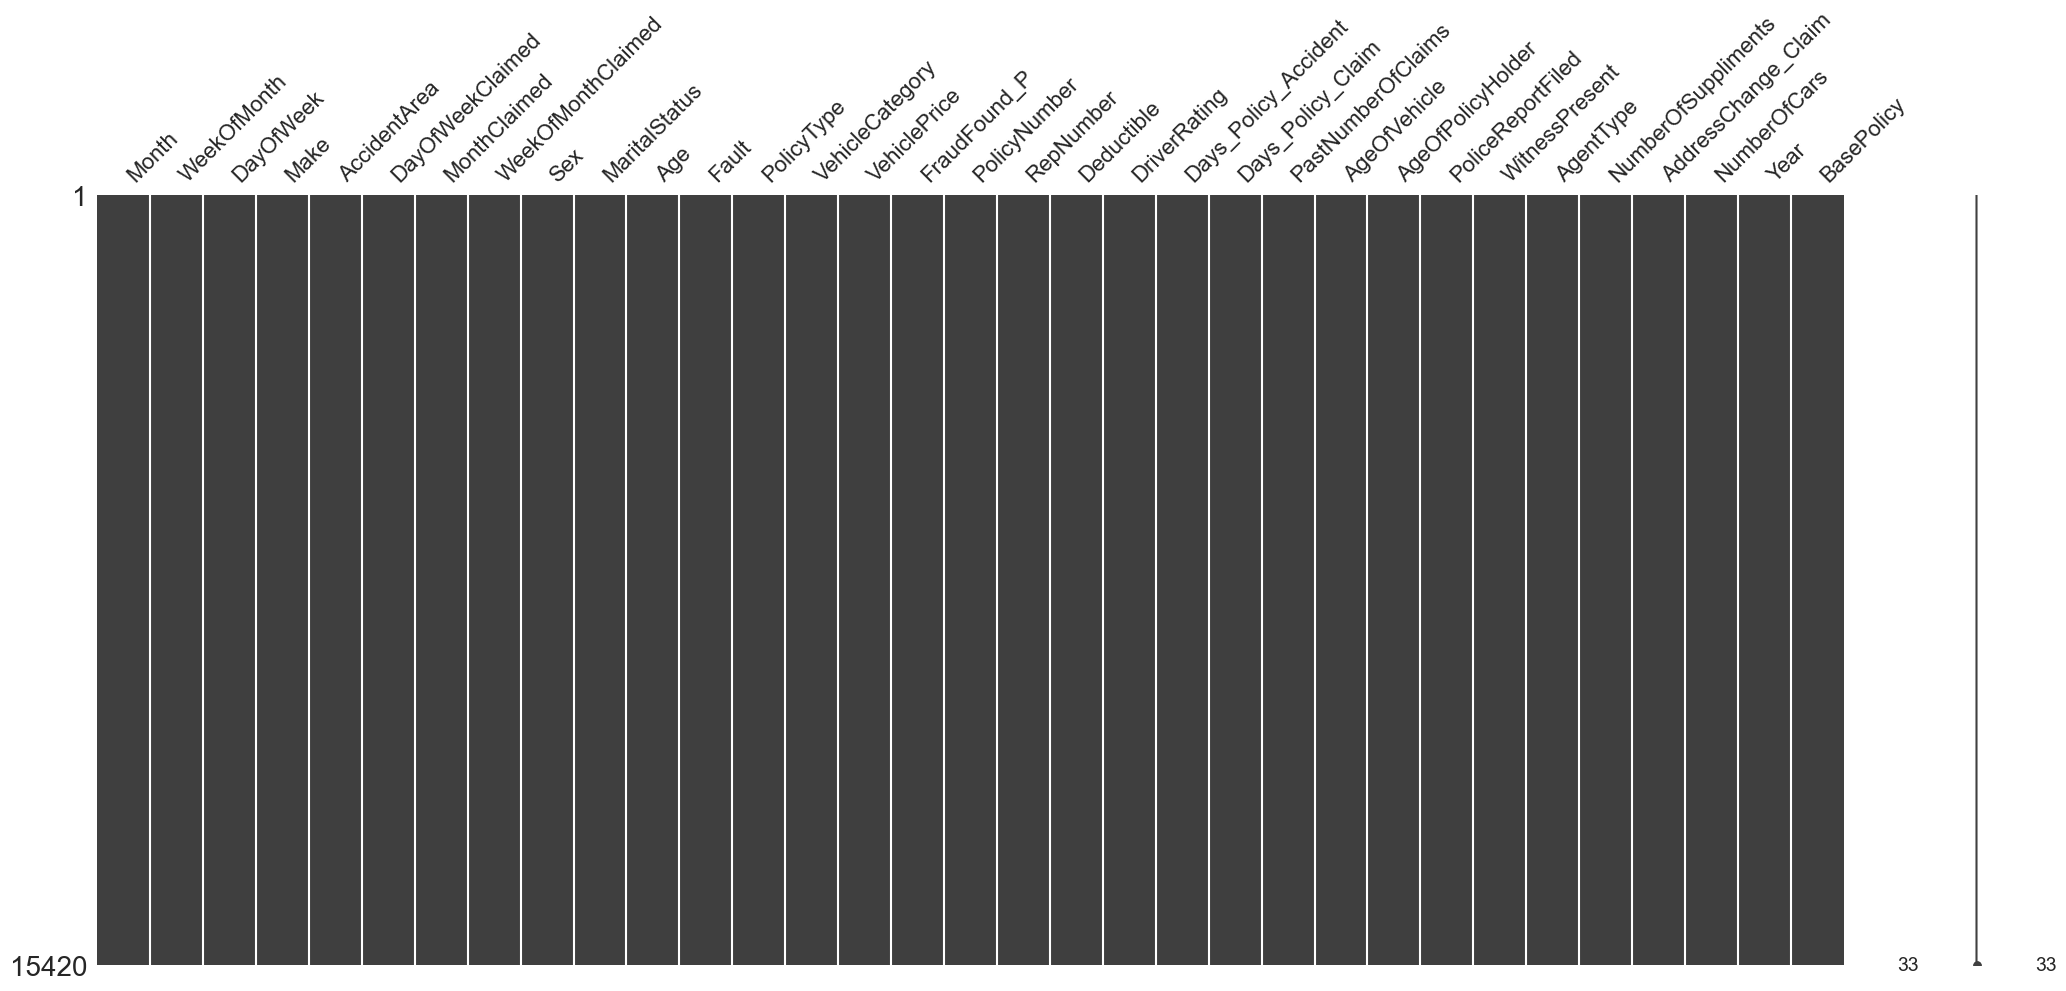

In [4]:
msno.matrix(raw_data);

**Point 01**: There is no missing value.

### 3) Characteristic of Dataset

In [5]:
def summarize(DataFrame):
    summary = pd.DataFrame()
    summary['DataType'] = DataFrame.dtypes
    summary['Nunique'] = DataFrame.nunique()
    summary['Unique'] = DataFrame.apply(lambda x: x.unique().tolist())
    summary['Max'] = DataFrame.apply(lambda x: x.max() if pd.api.types.is_numeric_dtype(x) else '-')

    # MEASURES OF CENTRAL TENDENCY: MEAN, MEDIAN, MODE
    summary['Mean'] = DataFrame.apply(lambda x: round(x.mean(), 2) if pd.api.types.is_numeric_dtype(x) else '-')
    summary['Median'] = DataFrame.apply(lambda x: x.median() if pd.api.types.is_numeric_dtype(x) else '-')
    summary['Mode'] = DataFrame.apply(lambda x: x.mode()[0] if not x.mode().empty else '-')

    # MEASURES OF DISPERSION: RANGE, VARIANCE, STANDARD DEVIATION
    summary['Range'] = DataFrame.apply(lambda x: x.max() - x.min() if pd.api.types.is_numeric_dtype(x) else '-')
    summary['Variance'] = DataFrame.apply(lambda x: x.var() if pd.api.types.is_numeric_dtype(x) else '-')
    summary['Std'] = DataFrame.apply(lambda x: x.std() if pd.api.types.is_numeric_dtype(x) else '-')

    # MEASURE OF SHAPE: SKEWNESS, KURTOSIS
    summary['Skewness'] = DataFrame.apply(lambda x: round(x.skew(), 2) if pd.api.types.is_numeric_dtype(x) else '-')
    summary['Kurtosis'] = DataFrame.apply(lambda x: round(x.kurt(), 2) if pd.api.types.is_numeric_dtype(x) else '-')

    return summary

summarize(raw_data).sort_values(by=['DataType', 'Nunique'])

,DataType,Nunique,Unique,Max,Mean,Median,Mode,Range,Variance,Std,Skewness,Kurtosis
FraudFound_P,int64,2,"[0, 1]",1,0.06,0.0,0,1,0.056278,0.23723,3.71,11.77
Year,int64,3,"[1994, 1995, 1996]",1996,1994.87,1995.0,1994,2,0.645312,0.803313,0.25,-1.41
Deductible,int64,4,"[300, 400, 500, 700]",700,407.7,400.0,400,400,1931.690221,43.950998,6.08,36.82
DriverRating,int64,4,"[1, 4, 3, 2]",4,2.49,2.0,1,3,1.253175,1.119453,0.01,-1.36
WeekOfMonth,int64,5,"[5, 3, 2, 4, 1]",5,2.79,3.0,3,4,1.657876,1.287585,0.12,-1.1
WeekOfMonthClaimed,int64,5,"[1, 4, 2, 3, 5]",5,2.69,3.0,2,4,1.585371,1.259115,0.16,-1.09
RepNumber,int64,16,"[12, 15, 7, 4, 3, 14, 1, 13, 11, 16, 6, 2, 8, ...",16,8.48,8.0,7,15,21.159523,4.599948,0.01,-1.19
Age,int64,66,"[21, 34, 47, 65, 27, 20, 36, 0, 30, 42, 71, 52...",80,39.86,38.0,30,80,182.044228,13.492377,0.15,0.8
PolicyNumber,int64,15420,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",15420,7710.5,7710.5,1,15419,19815985.0,4451.514911,0.0,-1.2
AccidentArea,object,2,"[Urban, Rural]",-,-,-,Urban,-,-,-,-,-


**Point 02**: 'PolicyNumber' is merely an identification number. Let's drop it

**Point 03**: The features 'Sex', 'PoliceReportFiled', and 'WitnessPresent' are actually **Boolean Types**. Should be converted to 0 or 1.

**Point 04**: The features 'AccidentArea', 'Fault' and 'AgentType' each have only two unique values. Can also be converted to 0 or 1.

**Point 05**: The minimum value if 'Age' is 0, which doesn't make sense. (Let's look into it later).

**Point 06**: The features 'FraudFound_P' and 'Deductible' are highly skewed. Tipically, a feature is considered skewed if its skewness falls outside the range of -0.5~0.5.

**Point 07**: The features 'WeekOfMonth', 'WeekOfMonthClaimed', 'FraudFound_P', 'Deductible' and 'DriverRating' exhibit high kurtosis. Tipically, a feature is considered to have high kurtosis if its values falls outside the range -1~1.

**Point 08**: Strictly speaking, among all the features, only 'Age' us a numeric variable. The rest can be interpreted as categorical variables.

# 🔎02. Exploratory Data Analysis (EDA)🔎

In [6]:
df_viz = raw_data.copy()
df_viz.shape

(15420, 33)

### 01) Target Variable Balanced - FraudFound_P

In [7]:
fraud_counts = df_viz['FraudFound_P'].value_counts().reset_index()
fraud_counts

,FraudFound_P,count
0,0,14497
1,1,923


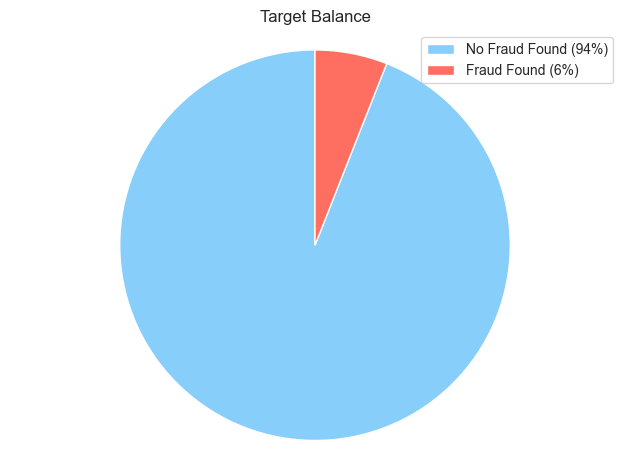

In [8]:
# PLT AND SNS PIE CHART
plt.title('Target Balance')
patches, text = plt.pie(fraud_counts['count'], colors=['#87CEFA', '#FF6F61'], startangle=90)
plt.legend(patches, [f'No Fraud Found ({(fraud_counts['count'][0]/fraud_counts['count'].sum())*100:.0f}%)', f'Fraud Found ({(fraud_counts['count'][1]/fraud_counts['count'].sum())*100:.0f}%)'], loc="best")
plt.axis('equal')
plt.tight_layout()

plt.show()

**Point 09**: The target variable 'FraudFound_P' is **highly imbalanced**

#### Issues caused by imbalanced target variable:
- **Model Bias**: The model may become biased towards the majority class, leading to poor performance on the minority class;
- **Misleading Metrics**: Metrics like accuracy can be misleading, as high accuracy can be achieved by simply predicting the majority class;
- **Poor Generalization**: The model may not generalize well to real-world scenarios where the minority class is important;

#### Necessity of Oversampling

- **Balanced Learning**: Balancing the dataset ensures that the model learns from all classes evenly. This leads to better performance across various scenarios when the model is deployed in real-world applications.

*Will be performed in the Data Preprocessing part*

### 02) Fraud Detection by Sex

In [9]:
df_fraud = df_viz[df_viz['FraudFound_P']==1]

fraud_counts_sex = df_fraud['Sex'].value_counts()
fraud_percentages_sex = (fraud_counts_sex / fraud_counts_sex.sum()) * 100

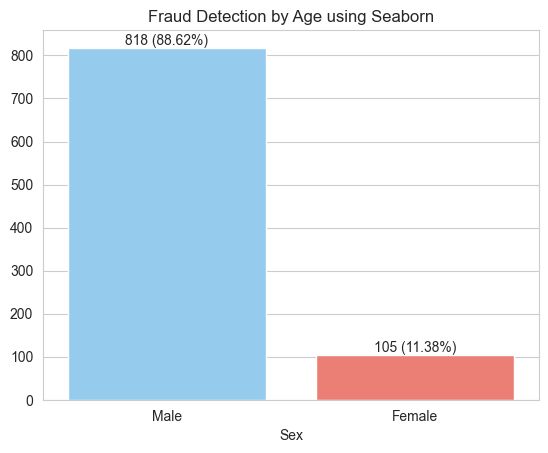

In [10]:
# SEABORN CHART

plt.title('Fraud Detection by Age using Seaborn')

ax = sns.barplot(x=fraud_counts_sex.index, y=fraud_counts_sex.values, hue=fraud_counts_sex.index, palette=sns.color_palette(['#87CEFA', '#FF6F61']))
for container in ax.containers:
    labels = [f'{i.get_height():.0f} ({(i.get_height()/fraud_counts_sex.sum())*100:.2f}%)' for i in container]
    ax.bar_label(container, labels=labels)

plt.show()

**Point 10**: This results suggest that males are significantly more likely to be involved in detected fraud cases compared to females.

### 03) Fraud Detection by Age & Age of Policy Holder

In [11]:
df_fraud = df_viz[df_viz['FraudFound_P']==1]
df_non_fraud = df_viz[df_viz['FraudFound_P']==0]

df_counts_age = df_viz['Age'].value_counts().sort_index()
df_counts_fraud_age = df_fraud['Age'].value_counts().sort_index()

df_percentages_fraud_age = round((df_counts_fraud_age/df_counts_age)*100, 2)

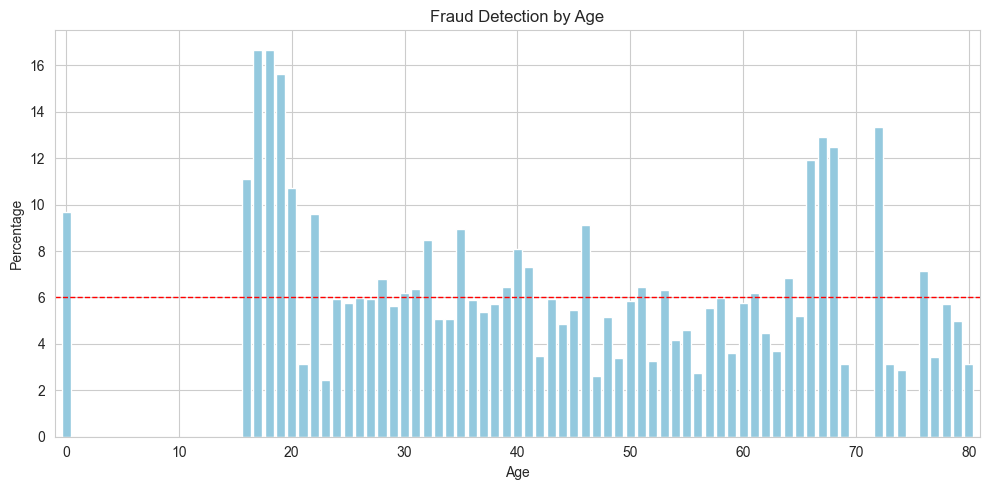

In [12]:
# SEABORN CHART

plt.figure(figsize=(10, 5))
ax = sns.barplot(x=df_percentages_fraud_age.index, y=df_percentages_fraud_age.values, color='skyblue', native_scale=True)
ax.hlines(y=6, xmin=df_percentages_fraud_age.index.min()-1, xmax=df_percentages_fraud_age.index.max()+1, colors='red', linestyles="--", linewidth=1)
ax.set_xlim(-1, df_percentages_fraud_age.index.max()+1)
ax.set_xticks(np.arange(0, df_percentages_fraud_age.index.max()+1, 10))
ax.set_xticklabels(np.arange(0, df_percentages_fraud_age.index.max()+1, 10))
ax.set_xlabel('Age')
ax.set_ylabel('Percentage')
ax.set_title('Fraud Detection by Age')

plt.tight_layout()
plt.show()

In [13]:
df_counts_ageofpolicyholder = df_viz['AgeOfPolicyHolder'].value_counts().sort_index()
df_counts_fraud_agepolicyholder = df_fraud['AgeOfPolicyHolder'].value_counts().sort_index()

df_percentages_fraud_agepolicyholder = round((df_counts_fraud_agepolicyholder/df_counts_ageofpolicyholder)*100, 2)

In [14]:
df_percentages_fraud_agepolicyholder

AgeOfPolicyHolder
16 to 17     9.69
18 to 20    13.33
21 to 25    14.81
26 to 30     5.38
31 to 35     6.44
36 to 40     5.86
41 to 50     5.09
51 to 65     5.03
over 65      5.91
Name: count, dtype: float64

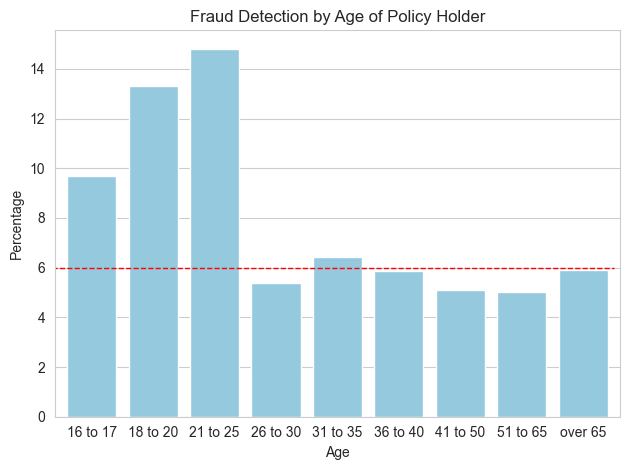

In [15]:
# SEABORN CHART

ax = sns.barplot(x=df_percentages_fraud_agepolicyholder.index, y=df_percentages_fraud_agepolicyholder.values, color='skyblue', native_scale=True, dodge=False)
ax.hlines(y=6, xmin=-1, xmax=df_percentages_fraud_agepolicyholder.count()-.5, colors='red', linestyles="--", linewidth=1)
ax.set_xlim(-.6, df_percentages_fraud_agepolicyholder.count()-.4)
ax.set_xlabel('Age')
ax.set_ylabel('Percentage')
ax.set_title('Fraud Detection by Age of Policy Holder')

plt.tight_layout()
plt.show()

**Point 11-1**: Fraud is mostr frequently detected among **teenagers** and **retired seniors**. Teenagers have weak financial power as they have not yet started their economic activities, and retired seniors experience weakened financial power post-retirement. Considering these points, there seem to be a correlation between financial power and fraud.

**Point 11-2**: Conversely, **only the under-25 age group** exhibits a high fraud rate in 'AgeOfPolicyHolder' feature.

### 04) Fraud Detection by Make

In [16]:
df_counts_make = df_viz['Make'].value_counts().sort_index()
df_counts_fraud_make = df_fraud['Make'].value_counts().sort_index()

df_percentages_fraud_make = round((df_counts_fraud_make/df_counts_make)*100,2).fillna(0).sort_values(ascending=False).reset_index()

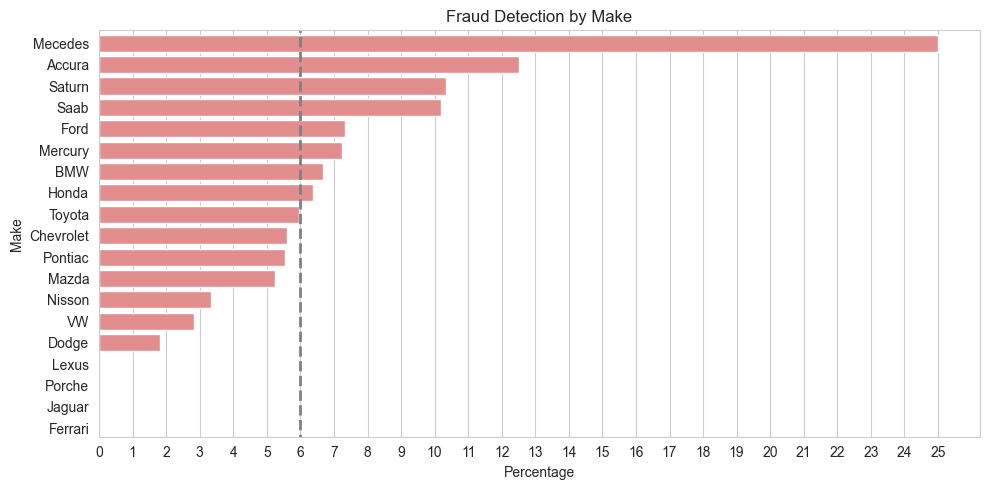

In [17]:
# SEABORN CHART

plt.figure(figsize=(10, 5))

ax = sns.barplot(df_percentages_fraud_make, x='count', y='Make', color='lightcoral')
ax.set_xticks(np.arange(0,df_percentages_fraud_make['count'].max()+1, 1))
ax.vlines(x=6, ymin=-1, ymax=df_percentages_fraud_make.index.max()+.4, colors='gray', linestyles="--", linewidth=2)
ax.set_ylim(df_percentages_fraud_make.index.max()+.4, -.6)
ax.set_xlabel('Percentage')
ax.set_title('Fraud Detection by Make')

plt.tight_layout()
plt.show()

**Point 12**: The **Mecedes owners** are more likely to be involved in fraud, with almost double the incidence compared to the 2nd highest group, Acura owners. On the other hand, the Lexus, Porche, Jaguar, Ferrari owners have never been reported for fraud - *all the four make are 'High-End'*. 

### 05) Fraud Detection by VehiclePrice

In [18]:
df_counts_vehicleprice = df_viz['VehiclePrice'].value_counts().sort_index()
df_counts_fraud_vehicleprice = df_fraud['VehiclePrice'].value_counts().sort_index()

df_percentages_fraud_vehicleprice = round((df_counts_fraud_vehicleprice/df_counts_vehicleprice)*100, 2).fillna(0).sort_values(ascending=False).reset_index()

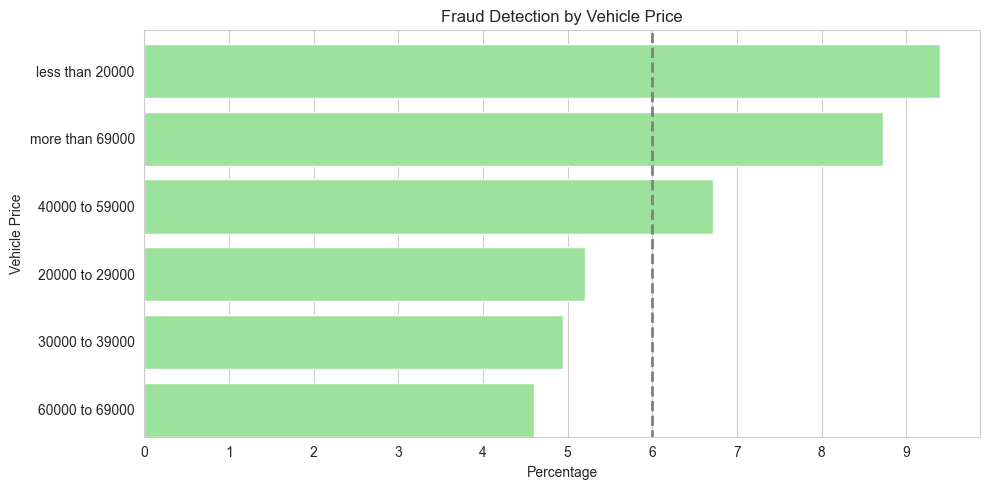

In [19]:
# SEABORN CHART

plt.figure(figsize=(10, 5))

ax = sns.barplot(df_percentages_fraud_vehicleprice, x='count', y='VehiclePrice', color='lightgreen')
ax.set_xticks(np.arange(0,df_percentages_fraud_vehicleprice['count'].max()+1, 1))
ax.vlines(x=6, ymin=-1, ymax=df_percentages_fraud_vehicleprice.index.max()+.4, colors='gray', linestyles="--", linewidth=2)
ax.set_ylim(df_percentages_fraud_vehicleprice.index.max()+.4, -.6)
ax.set_xlabel('Percentage')
ax.set_ylabel('Vehicle Price')
ax.set_title('Fraud Detection by Vehicle Price')

plt.tight_layout()
plt.show()

**Point 13**: Fraudulent cases were detected most frequently in either the most expensive or the cheapest vehicle category.

### 06) Fraud Detection by BasePolicy & PolicyType

In [20]:
# BASE POLICY

df_counts_policy = df_viz['BasePolicy'].value_counts().sort_index()
df_counts_fraud_policy = df_fraud['BasePolicy'].value_counts().sort_index()

df_percentages_fraud_policy = round((df_counts_fraud_policy/df_counts_policy)*100, 2).fillna(0).sort_values(ascending=False).reset_index()

# POLICY TYPE

df_counts_policy2 = df_viz['PolicyType'].value_counts().sort_index()
df_counts_fraud_policy2 = df_fraud['PolicyType'].value_counts().sort_index()

df_percentages_fraud_policy2 = round((df_counts_fraud_policy2/df_counts_policy2)*100, 2).fillna(0).sort_values(ascending=False).reset_index()

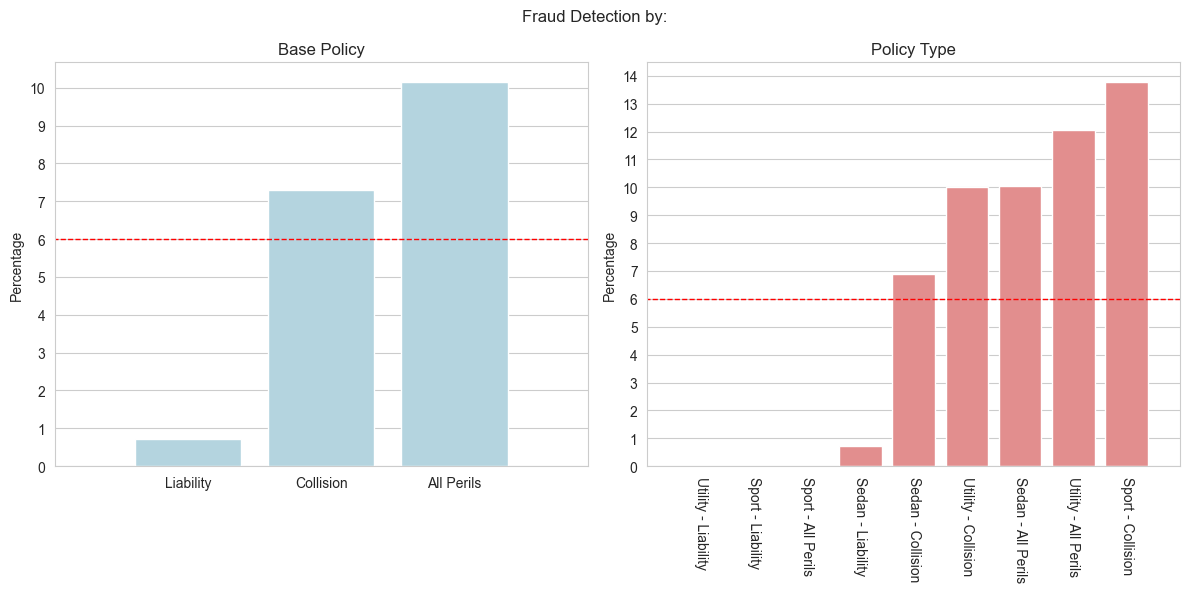

In [21]:
# SEABORN CHART

plt.figure(figsize=(12,6))
plt.suptitle('Fraud Detection by:')

plt.subplot(1,2,1)
ax = sns.barplot(df_percentages_fraud_policy, x='BasePolicy', y='count', color='lightblue')
ax.set_yticks(np.arange(0,df_percentages_fraud_policy['count'].max()+1, 1))
ax.hlines(y=6, xmin=-1, xmax=df_percentages_fraud_policy['count'].max()+.4, colors='red', linestyles="--", linewidth=1)
ax.set_xlim(df_percentages_fraud_policy['count'].count(), -1)
ax.set_ylabel('Percentage')
ax.set_xlabel('')
ax.set_title('Base Policy')

plt.subplot(1,2,2)
ax = sns.barplot(df_percentages_fraud_policy2, x='PolicyType', y='count', color='lightcoral')
ax.set_yticks(np.arange(0,df_percentages_fraud_policy2['count'].max()+1, 1))
ax.hlines(y=6, xmin=-1, xmax=df_percentages_fraud_policy2['count'].max()+.4, colors='red', linestyles="--", linewidth=1)
ax.set_xlim(df_percentages_fraud_policy2['count'].count(), -1)
ax.set_ylabel('Percentage')
ax.set_xlabel('')
ax.set_title('Policy Type')
plt.xticks(rotation=-90)

plt.tight_layout()

plt.show()

**Point 14**: Fraudulent cases were detected most frequently under the 'All Perils'. Within specify Policy Types, 'Sport-Colision', had the highest fraud detection rate.

### 07) Fraud Detection by Age of Vehicle

In [22]:
df_counts_agevehicle = df_viz['AgeOfVehicle'].value_counts().sort_index()
df_counts_fraud_agevehicle = df_fraud['AgeOfVehicle'].value_counts().sort_index()

df_percentages_fraud_agevehicle = round((df_counts_fraud_agevehicle/df_counts_agevehicle)*100, 2).sort_values(ascending=False).reset_index()

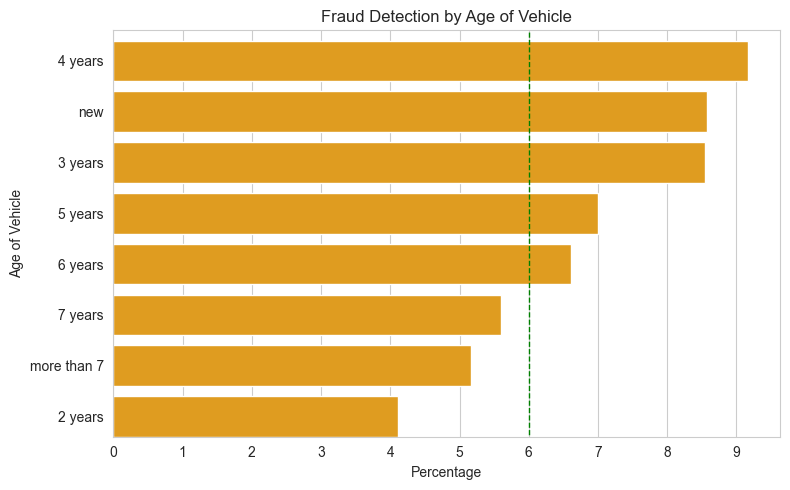

In [23]:
# SEABORN CHART

plt.figure(figsize=(8, 5))

ax = sns.barplot(df_percentages_fraud_agevehicle, x='count', y='AgeOfVehicle', color='orange')
ax.set_xticks(np.arange(0,df_percentages_fraud_agevehicle['count'].max()+1, 1))
ax.vlines(x=6, ymin=-1, ymax=df_percentages_fraud_agevehicle.index.max()+.4, colors='green', linestyles="--", linewidth=1)
ax.set_ylim(df_percentages_fraud_agevehicle.index.max()+.4, -.6)
ax.set_xlabel('Percentage')
ax.set_ylabel('Age of Vehicle')
ax.set_title('Fraud Detection by Age of Vehicle')

plt.tight_layout()
plt.show()

**Point 15**: The feature 'AgeOfVehicle' actually can be re-classified into 3 cateogires. The *highest*, *mid* and *low* fraudulent groups.

### 08) Fraud Detection by Month & MonthClaimed

In [24]:
df_counts_month = df_viz['Month'].value_counts().sort_index()
df_counts_fraud_month = df_fraud['Month'].value_counts().sort_index()

df_percentages_fraud_month = round((df_counts_fraud_month/df_counts_month)*100, 2).fillna(0).sort_values(ascending=False).reset_index()

df_counts_monthclaimed = df_viz['MonthClaimed'].value_counts().sort_index()
df_counts_fraud_monthclaimed = df_fraud['MonthClaimed'].value_counts().sort_index()

df_percentages_fraud_monthclaimed = round((df_counts_fraud_monthclaimed/df_counts_monthclaimed)*100, 2).fillna(0).sort_values(ascending=False).reset_index()



In [25]:
df_percentages_fraud_monthclaimed

,MonthClaimed,count
0,Aug,8.17
1,May,7.23
2,Mar,7.20
3,Apr,6.45
4,Jan,6.36
5,Sep,6.28
6,Feb,6.06
7,Jun,6.03
8,Oct,5.45
9,Jul,4.57


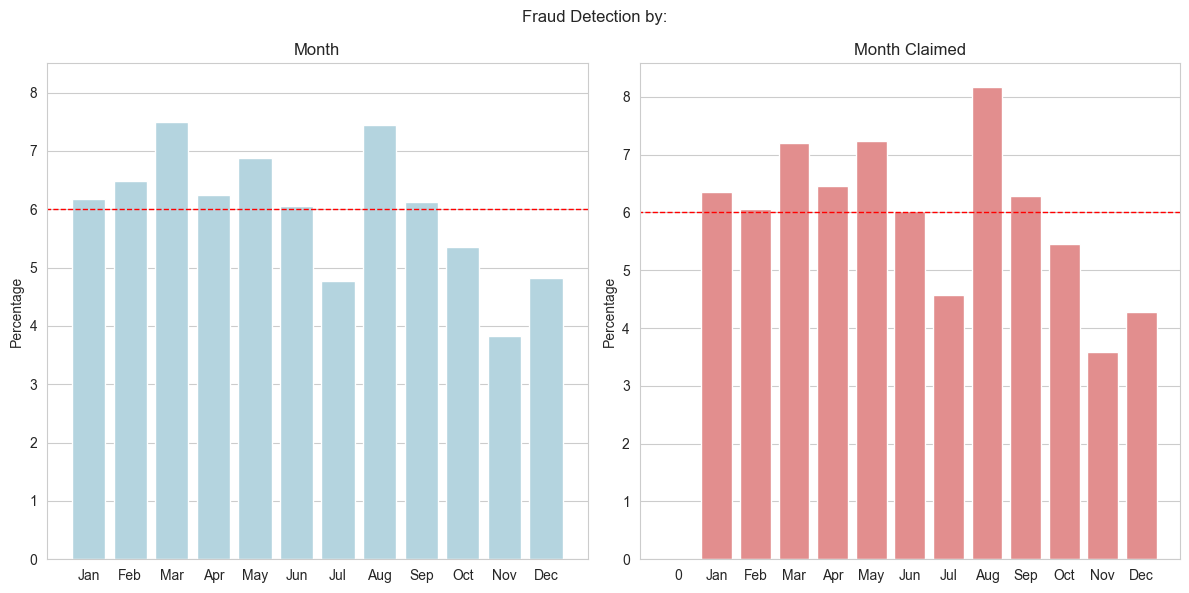

In [26]:
# SEABORN CHART

month_order = {'Jan':1, 'Feb':2, 'Mar':3, 'Apr':4, 'May':5, 'Jun':6, 'Jul':7, 'Aug':8, 'Sep':9, 'Oct':10, 'Nov':11, 'Dec':12}

plt.figure(figsize=(12,6))
plt.suptitle('Fraud Detection by:')
# sns.countplot(df.sort_values(by='Month', key=lambda x: x.map(month_order)), x='Month', hue='Season') #hue='FraudFound_P'

plt.subplot(1,2,1)
ax = sns.barplot(df_percentages_fraud_month.sort_values(by='Month', key=lambda x: x.map(month_order), ascending=False), x='Month', y='count', color='lightblue')
ax.set_yticks(np.arange(0,df_percentages_fraud_month['count'].count(), 1))
ax.hlines(y=6, xmin=-1, xmax=df_percentages_fraud_month['count'].count(), colors='red', linestyles="--", linewidth=1)
ax.set_xlim(df_percentages_fraud_month['count'].count(), -1)
ax.set_ylim(0, 8.5)
ax.set_ylabel('Percentage')
ax.set_xlabel('')
ax.set_title('Month')

plt.subplot(1,2,2)
ax = sns.barplot(df_percentages_fraud_monthclaimed.sort_values(by='MonthClaimed', key=lambda x: x.map(month_order), ascending=False), x='MonthClaimed', y='count', color='lightcoral')
ax.hlines(y=6, xmin=-1, xmax=df_percentages_fraud_monthclaimed['count'].count(), colors='red', linestyles="--", linewidth=1)
ax.set_xlim(df_percentages_fraud_monthclaimed['count'].count(), -1)
ax.set_ylabel('Percentage')
ax.set_xlabel('')
ax.set_title('Month Claimed')

plt.tight_layout()

plt.show()

**Point 16**: The features have similar distributions (no need to use both).

### 09) Fraud Detection by Season (Feature Engineering)

- **Season Observation Test**

In [27]:
seasons = {'Jan': 'Winter', 'Feb':'Winter', 'Mar':'Spring', 'Apr':'Spring', 'May':'Spring', 'Jun':'Summer', 'Jul':'Summer', 'Aug':'Summer', 'Sep':'Autumn', 'Oct':'Autumn', 'Nov':'Autumn', 'Dec':'Winter'}
season_order = {'Winter':1, 'Spring':2, 'Summer':3, 'Autumn':4}

df_viz_v2 = df_viz.copy()
df_viz_v2['Season'] = df_viz_v2['MonthClaimed'].map(seasons)

df_fraud_v2 = df_viz_v2[df_viz_v2['FraudFound_P']==1]

df_counts_fraud_season = df_fraud_v2['Season'].value_counts().sort_index()
df_counts_season = df_viz_v2['Season'].value_counts().sort_index()

df_percentages_fraud_season = round((df_counts_fraud_season/df_counts_season)*100, 2).fillna(0).sort_values(ascending=False).reset_index()
df_percentages_fraud_season

,Season,count
0,Spring,6.97
1,Summer,6.20
2,Winter,5.65
3,Autumn,5.10


In [28]:
df_viz_v2['MonthClaimed'] = df_viz_v2['MonthClaimed'].map(month_order)
df_viz_v2['Month'] = df_viz_v2['Month'].map(month_order)
df_viz_v2['Season'] = df_viz_v2['Season'].map(season_order)

In [29]:
corr_matrix = df_viz_v2.corr(numeric_only=True)
corr_matrix['FraudFound_P'].sort_values()

Age                  -0.029741
MonthClaimed         -0.028982
Month                -0.027278
Year                 -0.024760
PolicyNumber         -0.020345
WeekOfMonth          -0.011861
Season               -0.011663
RepNumber            -0.007551
WeekOfMonthClaimed   -0.005761
DriverRating          0.007266
Deductible            0.017348
FraudFound_P          1.000000
Name: FraudFound_P, dtype: float64

In [30]:
df_percentages_fraud_monthclaimed_v2 = df_percentages_fraud_monthclaimed.copy()
df_percentages_fraud_monthclaimed_v2['Season'] = df_percentages_fraud_monthclaimed_v2['MonthClaimed'].map(seasons)

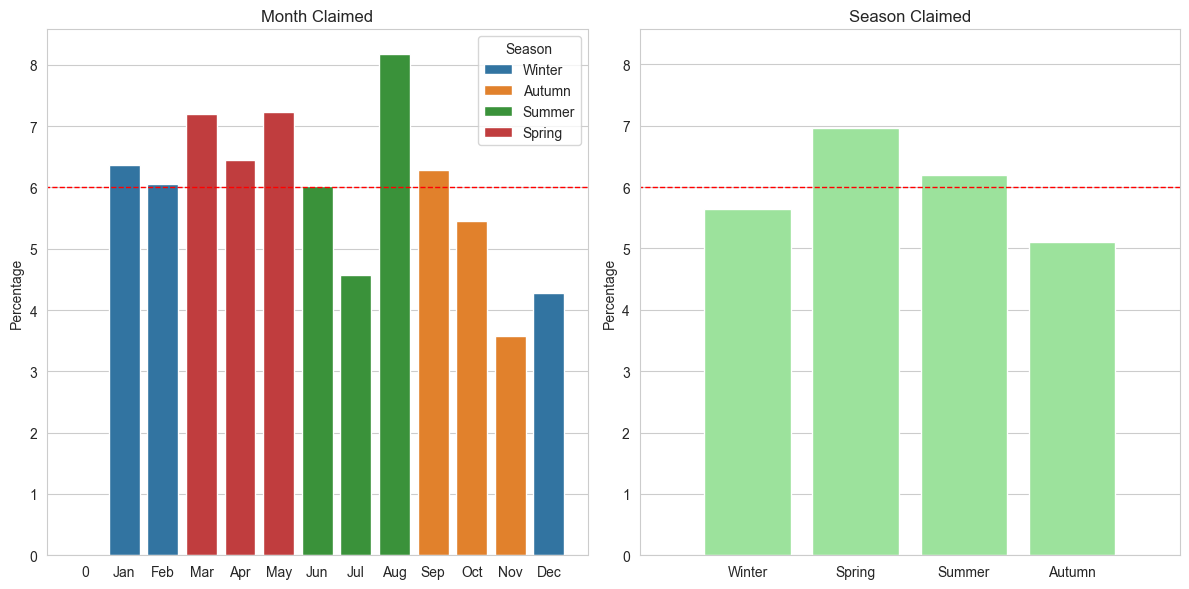

In [31]:
plt.figure(figsize=(12,6))

plt.subplot(1,2,1)
ax = sns.barplot(df_percentages_fraud_monthclaimed_v2.sort_values(by='MonthClaimed', key=lambda x: x.map(month_order), ascending=False), x='MonthClaimed', y='count', hue='Season', dodge=False)
ax.set_yticks(np.arange(0,df_percentages_fraud_monthclaimed_v2['count'].count(), 1))
ax.hlines(y=6, xmin=-1, xmax=df_percentages_fraud_monthclaimed_v2['count'].count(), colors='red', linestyles="--", linewidth=1)
ax.set_xlim(df_percentages_fraud_monthclaimed_v2['count'].count(), -1)
ax.set_ylabel('Percentage')
ax.set_xlabel('')
ax.set_title('Month Claimed')

plt.subplot(1,2,2)
ax = sns.barplot(df_percentages_fraud_season.sort_values(by='Season', key=lambda x: x.map(season_order), ascending=False), x='Season', y='count', color='lightgreen')
ax.hlines(y=6, xmin=-1, xmax=df_percentages_fraud_season['count'].count(), colors='red', linestyles="--", linewidth=1)
ax.set_ylim(0, df_percentages_fraud_monthclaimed_v2['count'].max()+.4)
ax.set_xlim(df_percentages_fraud_season['count'].count(), -1)
ax.set_ylabel('Percentage')
ax.set_xlabel('')
ax.set_title('Season Claimed')

plt.tight_layout()
plt.show()

**Point 16.1**: Maybe the 'Seasons' gives us a better generalization than the 'Month' itself.

# 🔄03. Data Preprocessing🔄

#### What is Data Preprocessing?
Data Preprocessing is the process of transforming raw data into a clean and usable format for analysis or machine learning models. It involves several steps to ensure the data is accurate, consistent, and ready for further processing.
Here are the main components of data preprocessing:

01) **Data Cleaning**: Handling Missing Values, Removing Duplicates, Correcting Inaccurate Data, Ensuring Consistency, Handling Outliers
02) **Data Integration**: Combining data from different sources into a coherent dataset.
03) **Data Transformation**: Normalization and Scaling, Encoding Categorical Variable, Feature Engineering, Aggregation
04) **Data Reduction**: Dimensionality Reduction, Feature Selection, Sampling
05) **Data Discretization**: Converting continous data into discrete buckets
06) **Data Splitting**: Dividing data into training, validation, and test sets.

In [32]:
df_clean_v1 = raw_data.copy()
df_clean_v1.shape

(15420, 33)

### 01) Data Transformation - Encoding Categorical Variables (**Binary Variable**) - Label Encoding

- AccidentArea, Sex, Fault, PoliceReportFiled, WitnessPresent and AgentType

In [33]:
binary_columns = [col for col in df_clean_v1.columns if df_clean_v1[col].nunique()==2 and col!='FraudFound_P']

print('The number of Binary Columns: ', len(binary_columns))
print('Binary Columns: ', binary_columns)

The number of Binary Columns:  6
Binary Columns:  ['AccidentArea', 'Sex', 'Fault', 'PoliceReportFiled', 'WitnessPresent', 'AgentType']


In [34]:
le = LabelEncoder()

for col in binary_columns:
    df_clean_v1[col] = le.fit_transform(df_clean_v1[col])
    print('Label Mapping: ', dict(zip(le.classes_, le.transform(le.classes_))))

Label Mapping:  {'Rural': 0, 'Urban': 1}
Label Mapping:  {'Female': 0, 'Male': 1}
Label Mapping:  {'Policy Holder': 0, 'Third Party': 1}
Label Mapping:  {'No': 0, 'Yes': 1}
Label Mapping:  {'No': 0, 'Yes': 1}
Label Mapping:  {'External': 0, 'Internal': 1}


### 02) Data Transformation - Encoding Categorical Variables (**Ordinal Categorical Variables & Nominal Categorical Variables**) - Label Encoding

- VehiclePrice, AgeOfVehicle and BasePolicy

In [35]:
cat_columns = ['VehiclePrice', 'AgeOfVehicle', 'BasePolicy']
for col in cat_columns:
    print(f'The unique values in {col}: {df_clean_v1[col].unique()}')

The unique values in VehiclePrice: ['more than 69000' '20000 to 29000' '30000 to 39000' 'less than 20000'
 '40000 to 59000' '60000 to 69000']
The unique values in AgeOfVehicle: ['3 years' '6 years' '7 years' 'more than 7' '5 years' 'new' '4 years'
 '2 years']
The unique values in BasePolicy: ['Liability' 'Collision' 'All Perils']


- I converted 'VehiclePrice' into a binary variable rather than an ordinal one. This decision was based on the fact that the categories 'more than 69000' and 'less than 20000' have the highest fraud rates, showing that the feature does not follow an ordinal pattern. (Please refer to ***Visualization 5***)
- I transformed 'AgeOfVehicle' into a nominal categorical variable for the same reason as 'VehiclePrice.' However, this feature can be re-classified into three categories. (Please refer to ***Visualization 7***)
- Only, 'BasePolicy' keeps its natural characteristic as a ordinal categorical variable. (Please refer to ***Visualization 6***)

In [36]:
vehicleprice_label = {
    'more than 69000' : 1,
    '20000 to 29000'  : 0,
    '30000 to 39000'  : 0,
    'less than 20000' : 0,
    '40000 to 59000'  : 0,
    '60000 to 69000'  : 1
}

ageofvehicle_label = {
    'new'         : 2,
    '2 years'     : 0,
    '3 years'     : 2,
    '4 years'     : 2,
    '5 years'     : 1,
    '6 years'     : 1,
    '7 years'     : 0,
    'more than 7' : 0,
}

basepolicy_label = {
    'Liability'  : 0,
    'Collision'  : 1,
    'All Perils' : 2
}

In [37]:
df_clean_v1['VehiclePrice'] = df_clean_v1['VehiclePrice'].map(vehicleprice_label)
df_clean_v1['AgeOfVehicle'] = df_clean_v1['AgeOfVehicle'].map(ageofvehicle_label)
df_clean_v1['BasePolicy'] = df_clean_v1['BasePolicy'].map(basepolicy_label)

In [38]:
df_clean_v2 = df_clean_v1.copy()
df_clean_v2.shape

(15420, 33)

### 03) Data Reduction - Feature Selecion 01 (Drop Useless Columns)

- I dropped 'Month' we already have similar feature 'Month Claimed' (Please refer to ***Visualization 8***)
- Also, I dropped other features related to *Date*

In [39]:
useless_cols = ['Month', 'WeekOfMonth', 'DayOfWeek', 'DayOfWeekClaimed', 'WeekOfMonthClaimed', 'PolicyNumber', 'AgeOfPolicyHolder']
df_clean_v3 = df_clean_v2.drop(useless_cols, axis=1)
df_clean_v3.shape

(15420, 26)

### 04) Data Transformation - One-Hot Encoding (Other categorical variables)

- I changed datatypes of some features into ***'string'*** before performing One-Hot Encoding to correct identification of categoris.

In [40]:
dtype_change_str = ['RepNumber', 'Deductible', 'Year']

for col in dtype_change_str:
    df_clean_v3[col] = df_clean_v3[col].astype(str)

In [41]:
onehot_enc_cols = ['Make', 'MonthClaimed', 'MaritalStatus', 'PolicyType', 'VehicleCategory', 'RepNumber', 'Deductible', 'Days_Policy_Accident', 'Days_Policy_Claim', 'PastNumberOfClaims', 'NumberOfSuppliments', 'AddressChange_Claim', 'NumberOfCars', 'Year']
print('The number of One-Hot encoding target features :', len(onehot_enc_cols))

The number of One-Hot encoding target features : 14


In [42]:
df_clean_v4 = pd.get_dummies(df_clean_v3, columns=onehot_enc_cols, dtype='int64')
df_clean_v4.shape

(15420, 110)

### 05) Data Reduction - Feature Selection 02 (Drop Constant Features)

In [43]:
onehot_encoded_cols = [col for col in df_clean_v4.columns if '_' in col]
onehot_encoded_cols.remove("FraudFound_P")
print("The Number of One-hot Encoded Columns: ", len(onehot_encoded_cols))

The Number of One-hot Encoded Columns:  98


In [44]:
const_features = []
for col in onehot_encoded_cols:
    if df_clean_v4[col].sum() <= 5:
        const_features.append(col)
print("The Number of Constant Features: ", len(const_features))

The Number of Constant Features:  9


In [45]:
df_clean_v4.drop(columns=const_features, axis=1, inplace=True)
df_clean_v4.shape

(15420, 101)

### 06) Data Cleaning - Correcting Inaccurate Data & Handling Outliers (Age) - **Outlier Replacement using LighGBM**

- 'Age' is the only (properly) numeric variable in this dataset.

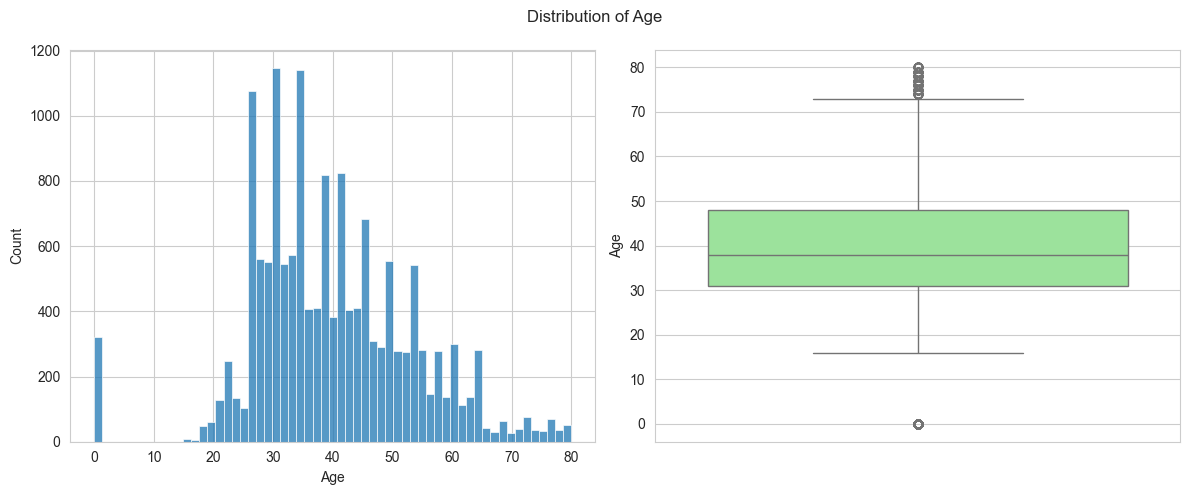

In [46]:
plt.figure(figsize=(12,5))
plt.suptitle('Distribution of Age')

plt.subplot(1,2,1)
ax = sns.histplot(df_viz, x='Age')

plt.subplot(1,2,2)
ax = sns.boxplot(df_viz, y='Age', color='lightgreen')

plt.tight_layout()
plt.show()

In [47]:
q1, q3 = np.percentile(df_viz['Age'], [25, 75])
iqr = q3-q1
minimum, maximum = [q1 - iqr*1.5, q3 + iqr*1.5]
print(f'Q1: {q1}')
print(f'Q3: {q3}')
print(f'IQR: {iqr}')
print(f'Minimum: {minimum}')
print(f'Maximum: {maximum}')

Q1: 31.0
Q3: 48.0
IQR: 17.0
Minimum: 5.5
Maximum: 73.5


As mentioned previously, it doesn't make sense to include 0 values. This dataset is 'Vehicle Claim Fraud Detection!' (Please refer to ***Point05***)

- I decided to handle the 0s in this feature and outliers at the same time.
- I performed Random Forest Imputation to change 0s and outliers (Over 74)

### Why Use **Light Gradient-Boosting Machine** (**LigthGBM**) for Outlier Replacement
- **High Accuracy**: Captures complex patterns and non-linear relationships.
- **Efficiency**: Fast training and scalable for large datasets.
- **Built-in Handling of Missing Values**: Natively manages missing data.
- **Regularization**: Prevents overfitting.

In [48]:
# FUNCTION FOR OUTLIER REPLACEMENT USING LIGHTGBM
def lightgbm_imputation(dataframe, feature):
    df_copy = dataframe.copy()
    train_data = df_copy[df_copy[feature].notnull()]
    test_data = df_copy[df_copy[feature].isnull()]

    X_train = train_data.drop([feature], axis=1)
    y_train = train_data[feature]
    X_test = test_data.drop([feature], axis=1)

    train_dataset = lgb.Dataset(data=X_train, label=y_train)

    params = {
        'objective': 'regression',
        'metric': 'rmse', # ROOT MEAN SQUARED ERROR
        'boosting_type': 'gbdt',
        'verbose': -1,
    }

    model = lgb.train(params, train_dataset, num_boost_round=100)

    predictions = model.predict(X_test)

    df_copy.loc[df_copy[feature].isnull(), feature] = predictions

    return df_copy

In [49]:
# CHANGE 0s AND OUTLIERS INTO NULL VALUES
df_clean_v4['Age'] = df_clean_v4['Age'].apply(lambda x: np.nan if x==0 or x>74 else x)

In [50]:
# APPLY LIGHTGBM IMPUTATION
df_imputed = lightgbm_imputation(df_clean_v4, 'Age')

In [51]:
# ROUND UP FLOATS
df_imputed['Age'] = df_imputed['Age'].apply(lambda x: round(x))

In [52]:
# ORGANIZE AGES IN GROUPS AS IT WAS BACK IN 'AgePolicyHolder'
def categorize_age(age):
    if age <= 20:
        return 0
    elif age <= 40:
        return 1
    elif age <= 65:
        return 2
    else:
        return 3


In [53]:
df_imputed['Age'] = df_imputed['Age'].apply(categorize_age)

In [54]:
df_clean_v5 = df_imputed.copy()
df_clean_v5.shape

(15420, 101)

# ⚙️04. SMOTE Oversampling - Synthetic Minority Oversampling Technique⚙️

The **Synthetic Minority Over-sampling Technique (SMOTE)** is a method used in machine learning to address the issue of **imbalanced datasets**. Imbalanced datasets are common in classification problems, especially **Fraud Detection datasets**, where one class (often the minority class) has significantly fewer instances than the other class(es). SMOTE aims to balance the class distribution by generating synthetic examples from the minority class.

In [55]:
X = df_clean_v5.drop('FraudFound_P', axis=1)
y = df_clean_v5['FraudFound_P']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=42)

In [56]:
smote = SMOTE(random_state=0)
X_train_over, y_train_over = smote.fit_resample(X_train, y_train)

print('Before SMOTE: ', X_train.shape, y_train.shape)
print('After SMOTE: ', X_train_over.shape, y_train_over.shape, end='\n\n')
print('Before SMOTE Label Distribution: ', pd.Series( y_train).value_counts())
print('After SMOTE Label Distribution: ', pd.Series(y_train_over).value_counts())


Before SMOTE:  (12336, 100) (12336,)
After SMOTE:  (23220, 100) (23220,)

Before SMOTE Label Distribution:  FraudFound_P
0    11610
1      726
Name: count, dtype: int64
After SMOTE Label Distribution:  FraudFound_P
0    11610
1    11610
Name: count, dtype: int64


In [57]:
df_smote = pd.concat([X_train_over, y_train_over], axis=1)
df_smote.shape

(23220, 101)

Now we have a **Balanced Dataset**!

# ✅06. RFECV Feature Selection - Recursive Feature Elimination Cross Validation (+ Variance Threshold Method)✅

What is Recursive Feature Elimination Cross Validation (**RFECV**)?

**Recursive Feature Elimination Cross Validation** (**RFECV**) is a feature selection method that recursively removes less important features based on a specified estimator's performance. It combines the process of Recursive **Feature Elimination** (**RFE**) with **Cross-Validation** (**CV**) to determine the optimal number of features that yield the best model performance.

It is Recursive because they took the following approach:
1. Train a ML model;
2. Obtain feature importance;
3. Remove least important feature(s) based on a specified performance measure;
4. Re-Train ML model with remaining features;

In [58]:
X_smote = df_smote.drop('FraudFound_P', axis=1)
y_smote = df_smote['FraudFound_P']
print(X_smote.shape, y_smote.shape)

(23220, 100) (23220,)


Before moving forward to the RFECV, I performed Pre-feature-selection using **VarianceThreshold**

**VarianceThreshold** is a feature selection method that removes features with low variance. Features with variance below a specified threshold are considered to have little informational value because they exhibit little variability across samples.

- **Reduce noise**: Eliminates features that do not vary much, which are less likely to be informative.
- **Simplifies the model**: Reduces the number of features, making the model simpler and faster. (This is the reason I performed this before RFECV!)
- **Prevents overfitting**: Helps in reducing the risk of overfitting by removing uninformative features.

In [59]:
# VarianceThreshold
selector = VarianceThreshold(threshold=0.01) # The larger the threshold, the more features are eliminated.
X_reduced = selector.fit_transform(X_smote)
X_reduced.shape

(23220, 76)

In [60]:
selected_feature_indices = selector.get_support(indices=True)
selected_feature_names = X_smote.columns[selected_feature_indices]
X_reduced = pd.DataFrame(X_reduced, columns=selected_feature_names)

In [61]:
drop_features = [s for s in X_smote.columns if s not in X_reduced.columns]                  # store common elements
print("Features to drop: ", len(drop_features), drop_features)      

Features to drop:  24 ['WitnessPresent', 'AgentType', 'Make_BMW', 'Make_Dodge', 'Make_Jaguar', 'Make_Mercury', 'Make_Nisson', 'Make_Saab', 'Make_Saturn', 'MaritalStatus_Divorced', 'MaritalStatus_Widow', 'PolicyType_Sport - All Perils', 'PolicyType_Utility - Collision', 'PolicyType_Utility - Liability', 'Deductible_300', 'Days_Policy_Accident_1 to 7', 'Days_Policy_Accident_15 to 30', 'Days_Policy_Accident_8 to 15', 'Days_Policy_Accident_none', 'Days_Policy_Claim_15 to 30', 'Days_Policy_Claim_8 to 15', 'Days_Policy_Claim_more than 30', 'AddressChange_Claim_1 year', 'NumberOfCars_5 to 8']


Starting **RFECV** method:

In [62]:
# LightGBM
lightgbm_model = lgb.LGBMClassifier(n_estimators=100, learning_rate=0.1, random_state=42, verbose=-1)

I used **ROC_AUC** as a scoring parameter because, in fraud detection, it is important to consider both accuracy and recall. For more details about scoring metrics, please refer to the following link: https://www.v7labs.com/blog/f1-score-guide

In [63]:
rfecv = RFECV(estimator=lightgbm_model ,step=1, cv=StratifiedKFold(5), scoring='roc_auc', n_jobs=-1)
rfecv.fit(X_reduced, y_smote)

RFECV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
      estimator=LGBMClassifier(random_state=42, verbose=-1), n_jobs=-1,
      scoring='roc_auc')

In [64]:
print('Optimal number of features: ', rfecv.n_features_)

Optimal number of features:  72


In [65]:
X_selected = rfecv.transform(X_reduced)

In [66]:
selected_feature_indices = np.where(rfecv.support_)[0]
selected_feature_names = X_reduced.columns[selected_feature_indices]
X_rfecv = pd.DataFrame(X_selected, columns=selected_feature_names)

# 🤖06. Modeling - Optimization using Optuna🤖

**What is Optuna?**

Optuna is an automatic hyperparameter optimization framework designed to enhance the performance of machine learning models. It offers a flexible and efficient approach to finding the best hyperparameters by using techniques like **Bayesian Optimization**. Optuna allows users to define an objective function, which it then optimizes through a series of trials, intelligently searching the hyperparameter space.

In summary, **Optuna** is a **more advanced** and efficient tool for hyperparameter optimization compared to **GridSearch**, offering flexibility, intelligent sampling, and resource-saving features like pruning.

***Algorithms:***

- ***Logistics Regression:*** A linear model for binary classification that predicts probabilities.
- ***Support Vector Machine (SVM):*** Classifies data by finding the hyperplane that maximizes the margin between classes.
- ***K-Nearest Neighbors (KNN):*** Predicts the class based on the majority class among the k nearest neighbors.
- ***RandomForest:*** An ensemble of decision trees that improves classification accuracy by averaging multiple trees.
- ***LightGBM:*** A gradient boosting framework that uses tree-based learning algorithms, optimized for speed and efficiency.
- ***CatBoost:*** A gradient boosting algorithm that handles categorical features automatically, designed for high performance and accuracy.

In [67]:
rfecv_cols = X_rfecv.columns
X_rfecv_test = X_test[rfecv_cols]

### 01) Modeling - Optuna 

In [74]:
# Function04: Objective
def objective(trial):
    classifier_name = trial.suggest_categorical('classifier', [
        'LogisticRegression', 'SVM', 'KNeighbors', 'RandomForest', 'LightGBM'
    ])
    
    if classifier_name == 'LogisticRegression':
        C = trial.suggest_float('lr_C', 0.1, 10)
        solver = trial.suggest_categorical('lr_solver', ['liblinear'])
        classifier_obj = LogisticRegression(C=C, solver=solver)
    
    elif classifier_name == 'SVM':
        C = trial.suggest_float('svm_C', 0.1, 10)
        kernel = trial.suggest_categorical('svm_kernel', ['linear', 'rbf'])
        classifier_obj = SVC(C=C, kernel=kernel, probability=True)
    
    elif classifier_name == 'KNeighbors':
        n_neighbors = trial.suggest_int('kn_n_neighbors', 3, 7)
        classifier_obj = KNeighborsClassifier(n_neighbors=n_neighbors)
    
    elif classifier_name == 'RandomForest':
        n_estimators = trial.suggest_int('rf_n_estimators', 100, 200)
        max_depth = trial.suggest_categorical('rf_max_depth', [10, 20, None])
        classifier_obj = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth)
    
    elif classifier_name == 'LightGBM':
        num_leaves = trial.suggest_int('lgb_num_leaves', 31, 50)
        learning_rate = trial.suggest_float('lgb_learning_rate', 0.01, 0.2)
        n_estimators = trial.suggest_int('lgb_n_estimators', 100, 200)
        classifier_obj = lgb.LGBMClassifier(num_leaves=num_leaves, learning_rate=learning_rate, n_estimators=n_estimators, verbose=-1)
    
    classifier_obj.fit(X_rfecv, y_smote)
    y_prob = classifier_obj.predict_proba(X_rfecv_test)[:, 1]
    
    # Threshold optimization
    thresholds = np.arange(0.1, 0.9, 0.01)
    best_threshold = 0.5
    best_score = 0.0
    
    for threshold in thresholds:
        y_pred = (y_prob >= threshold).astype(int)
        score = f1_score(y_test, y_pred)
        if score > best_score:
            best_score = score
            best_threshold = threshold
    
    trial.set_user_attr('best_threshold', best_threshold)
    trial.set_user_attr('classifier_obj', classifier_obj)
    return roc_auc_score(y_test, (y_prob >= best_threshold).astype(int))

In [75]:
# Optuna Study
study = optuna.create_study(direction='maximize', sampler=optuna.samplers.TPESampler())
study.optimize(objective, n_trials=100)

[I 2024-07-10 18:11:04,079] A new study created in memory with name: no-name-0880c120-e258-4162-8c9c-5979a7eedb26
[I 2024-07-10 18:11:06,254] Trial 0 finished with value: 0.6725334468007294 and parameters: {'classifier': 'RandomForest', 'rf_n_estimators': 122, 'rf_max_depth': 20}. Best is trial 0 with value: 0.6725334468007294.
[I 2024-07-10 18:11:06,668] Trial 1 finished with value: 0.73344099841931 and parameters: {'classifier': 'LightGBM', 'lgb_num_leaves': 47, 'lgb_learning_rate': 0.0907842200561203, 'lgb_n_estimators': 138}. Best is trial 1 with value: 0.73344099841931.
[I 2024-07-10 18:11:08,937] Trial 2 finished with value: 0.7269072456785978 and parameters: {'classifier': 'RandomForest', 'rf_n_estimators': 123, 'rf_max_depth': 20}. Best is trial 1 with value: 0.73344099841931.
[I 2024-07-10 18:11:44,976] Trial 3 finished with value: 0.6458516120751346 and parameters: {'classifier': 'SVM', 'svm_C': 7.467378095454768, 'svm_kernel': 'rbf'}. Best is trial 1 with value: 0.7334409984

In [76]:
best_trial = study.best_trial
print('Best trial: ', best_trial.values)
print('Best hyperparameters: ', best_trial.params)

Best trial:  [0.7529499471638134]
Best hyperparameters:  {'classifier': 'RandomForest', 'rf_n_estimators': 177, 'rf_max_depth': 20}


In [77]:
# Optimized Alogrithm Combination
best_algorithms = [trial.params['classifier'] for trial in study.trials]
algorithm_counts = pd.Series(best_algorithms).value_counts()
print('Optimal algorithm proportions: ', algorithm_counts)

Optimal algorithm proportions:  RandomForest          59
LightGBM              19
KNeighbors             8
SVM                    7
LogisticRegression     7
Name: count, dtype: int64


In [78]:
# Function05: Evaluation
def evaluate_model(model, X_train, y_train, X_test, y_test, threshold):
    model.fit(X_train, y_train)
    y_prob = model.predict_proba(X_test)[:, 1]
    y_pred = (y_prob >= threshold).astype(int)

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_prob)
    
    return accuracy, precision, recall, f1, roc_auc

In [80]:
top_5_trials = study.trials_dataframe().sort_values(by='value', ascending=False).head(5)
results = []

for i, row in top_5_trials.iterrows():
    model_name = row['params_classifier']
    threshold = study.trials[row['number']].user_attrs['best_threshold']
    model_params = study.trials[row['number']].params

    if model_name == 'LogisticRegression':
        params = {'C': model_params['lr_C'], 'solver': model_params['lr_solver']}
        final_model = LogisticRegression(**params)
    elif model_name == 'SVM':
        params = {'C': model_params['svm_C'], 'kernel': model_params['svm_kernel']}
        final_model = SVC(**params, probability=True)
    elif model_name == 'KNeighbors':
        params = {'n_neighbors': model_params['kn_n_neighbors']}
        final_model = KNeighborsClassifier(**params)
    elif model_name == 'RandomForest':
        params = {'n_estimators': model_params['rf_n_estimators'], 'max_depth': model_params['rf_max_depth']}
        final_model = RandomForestClassifier(**params)
    elif model_name == 'LightGBM':
        params = {'num_leaves': model_params['lgb_num_leaves'], 'learning_rate': model_params['lgb_learning_rate'], 'n_estimators': model_params['lgb_n_estimators']}
        final_model = lgb.LGBMClassifier(**params, verbose=-1)

    accuracy, precision, recall, f1, roc_auc = evaluate_model(final_model, X_rfecv, y_smote, X_rfecv_test, y_test, threshold)
    
    results.append({
        'model': model_name,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'roc_auc': roc_auc,
        'best_params': params,
        'best_threshold': threshold
    })

results_df = pd.DataFrame(results)

In [81]:
results_df

,model,accuracy,precision,recall,f1_score,roc_auc,best_params,best_threshold
0,RandomForest,0.738003,0.162431,0.746193,0.266788,0.819768,"{'n_estimators': 177, 'max_depth': 20}",0.28
1,RandomForest,0.742866,0.164414,0.741117,0.269124,0.816614,"{'n_estimators': 170, 'max_depth': 10}",0.49
2,RandomForest,0.765240,0.171036,0.695431,0.274549,0.821595,"{'n_estimators': 182, 'max_depth': 20}",0.31
3,RandomForest,0.735409,0.160263,0.741117,0.263538,0.814120,"{'n_estimators': 177, 'max_depth': 10}",0.48
4,RandomForest,0.767510,0.169211,0.675127,0.270600,0.819158,"{'n_estimators': 134, 'max_depth': 20}",0.31


### 02) Visualization - Feature Importance

In [82]:
best_model_info = results_df.iloc[0]
best_model = best_model_info['model']
best_model_params = best_model_info['best_params']
best_threshold = best_model_info['best_threshold']

final_model = None
if best_model == 'LogisticRegression':
    final_model = LogisticRegression(**best_model_params)
elif best_model == 'SVM':
    final_model = SVC(**best_model_params, probability=True)
elif best_model == 'KNeighbors':
    final_model = KNeighborsClassifier(**best_model_params)
elif best_model == 'RandomForest':
    final_model = RandomForestClassifier(**best_model_params)
elif best_model == 'LightGBM':
    final_model = lgb.LGBMClassifier(**best_model_params, verbose=-1)

final_model.fit(X_rfecv, y_smote)
result = permutation_importance(final_model, X_rfecv_test, y_test, n_repeats=10, random_state=42)
feature_importance = result.importances_mean
features = X_rfecv.columns

importance_df = pd.DataFrame({
    'feature': features,
    'importance': feature_importance
}).sort_values(by='importance', ascending=False)